## Time Series Forecasting
Time Series Forecasting involves utilizing past historical data to predict future values at future time periods. There are many methods that can be used for forecasting, in statistical or machine learning models.

Since our data is affected by seasonality, where there are different outputs depending on specific periods of time, we will implement data pipelines which utilize models that address seasonality. We will use a machine learning approach we will be utilizing Facebook's PROPHET library, which captures non-linear complex relationships within data and between features well as well as be able to handle missing values.

Our data are daily sales in Ecuardorian markets from Kaggle.
 

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 

In [3]:
sale_df = pd.read_csv(r"C:\Users\cecil\OneDrive\Desktop\Projects\data\timesales_train.csv") 
sale_df
##Check date ranges of datasets
#min(sale_df['date']), max(sale_df['date'])
# min(sale_df_test['date']), max(sale_df_test['date'])
#use past historical date train to compare as 'validation', then final model forecast

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [4]:
print(f'{sale_df.dtypes}\n')
#Number of Nulls in each column
print(f'{sale_df.isna().sum()}\n')
#Rows of data
print(sale_df.shape)

# sale_df['family'].unique().sum()

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

(3000888, 6)


#### Preprocessing Data

In [5]:
#Change date into datetime datatype
sale_df['date'] = pd.to_datetime(sale_df.date)

#Change product family into string
def fam_to_str(family):
    return str(family).replace('\n1', '')

sale_df['family'] = sale_df['family'].apply(fam_to_str)

#Deal With Missing Data
not_sold = len(sale_df.loc[sale_df['sales'].isna()])/len(sale_df) * 100

print(f'The proportion of missing data is: {round(not_sold,2)} %')
sale_df = sale_df.loc[sale_df['sales'].notna()]

num_cat = len(sale_df['family'].unique().tolist())
print(f'The number of categories is: {num_cat}')

The proportion of missing data is: 0.0 %
The number of categories is: 33


We would like to explore our initial data to see if the data is sufficient for forecasting. We would like sales at least in the thousands on a daily basis, as we need high-volume metrics to ensure reliabiity and reduce noise. We will visualize the total sales grouped by family (product category) in daily-level

In [6]:
"""
Visualize Total Sales Revenue of each Product
"""
prod_total_sale = sale_df.groupby(by = ['date', 'family']).agg({'sales': 'sum'}).reset_index().sort_values(by = ['family', 'date'])
prod_total_sale.head()

,date,family,sales
0,2013-01-01,AUTOMOTIVE,0.0
33,2013-01-02,AUTOMOTIVE,255.0
66,2013-01-03,AUTOMOTIVE,161.0
99,2013-01-04,AUTOMOTIVE,169.0
132,2013-01-05,AUTOMOTIVE,342.0


In [7]:
""""
Visualizing Total Sales Revenue for each product
"""
#Pivoting dataframe to have family as column
prod_sales = prod_total_sale.pivot(index="date", columns="family", values="sales")
prod_sales.head(2)

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,2.0,810.0,0.0,180.589,0.0,186.0,143.0,71.09,...,0.0,110.801000,25.0,0.0,0.0,42.637000,37.847000,0.0,0.0,0.000000
2013-01-02,255.0,0.0,207.0,72092.0,0.0,26246.319,0.0,74629.0,23381.0,15754.50,...,0.0,20871.464028,17204.0,0.0,0.0,13975.884938,5338.111976,0.0,0.0,1526.750002


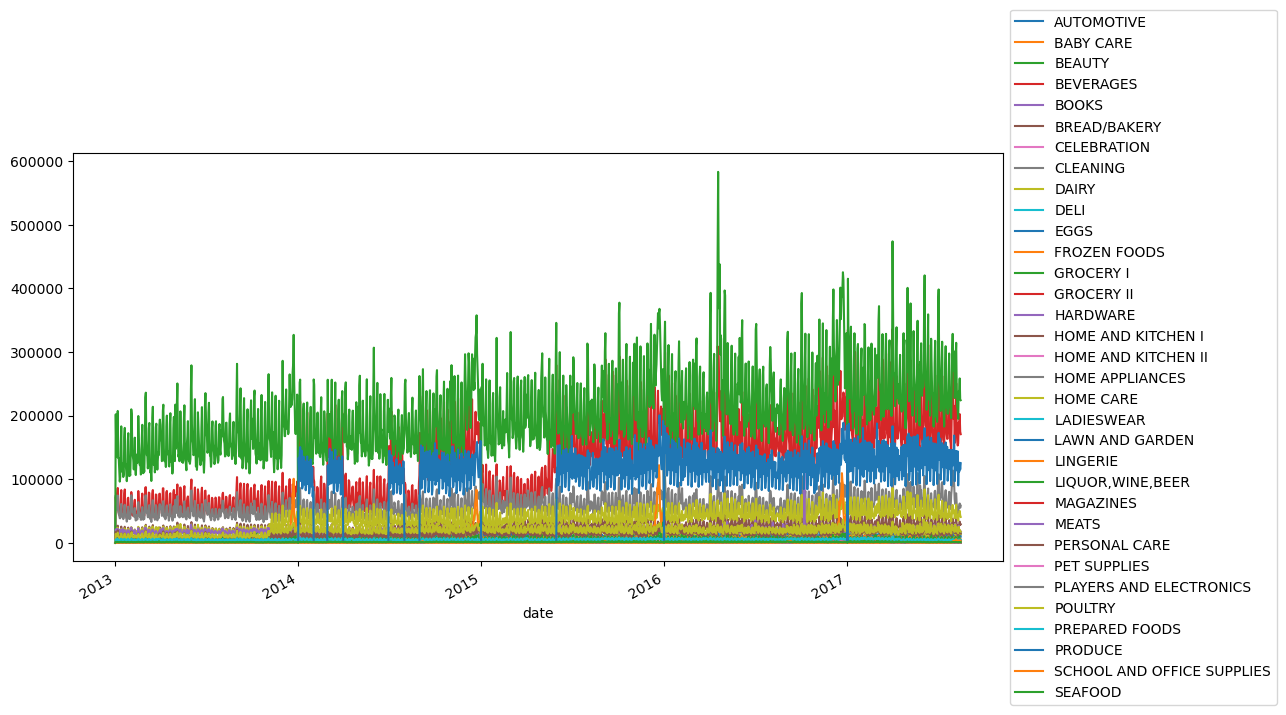

In [8]:
#Overlaid categories
prod_sales.plot()

plt.gcf().set_size_inches(12, 6)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

C:\Users\cecil\AppData\Local\Temp\ipykernel_16636\2113559898.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 1000x500 with 0 Axes>

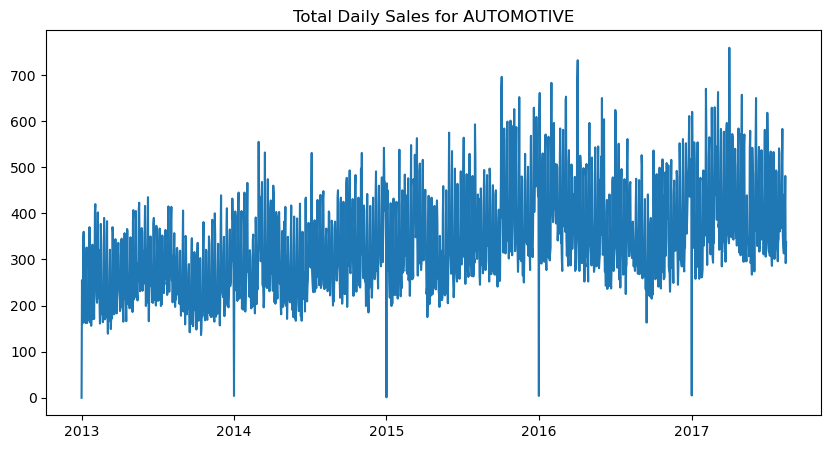

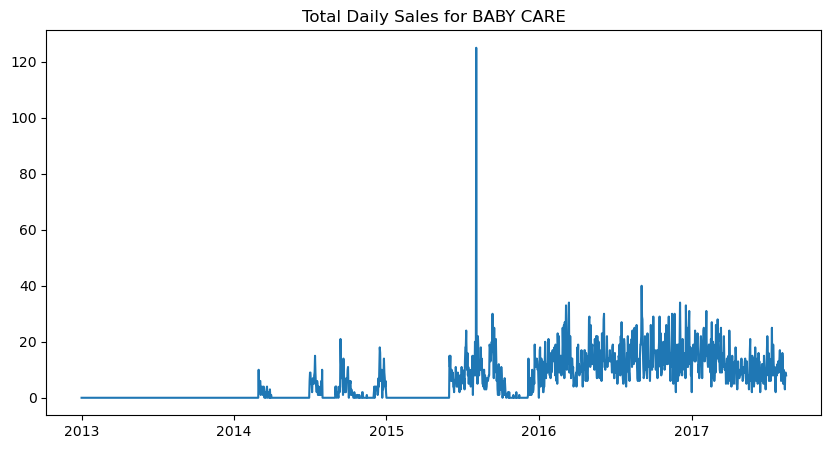

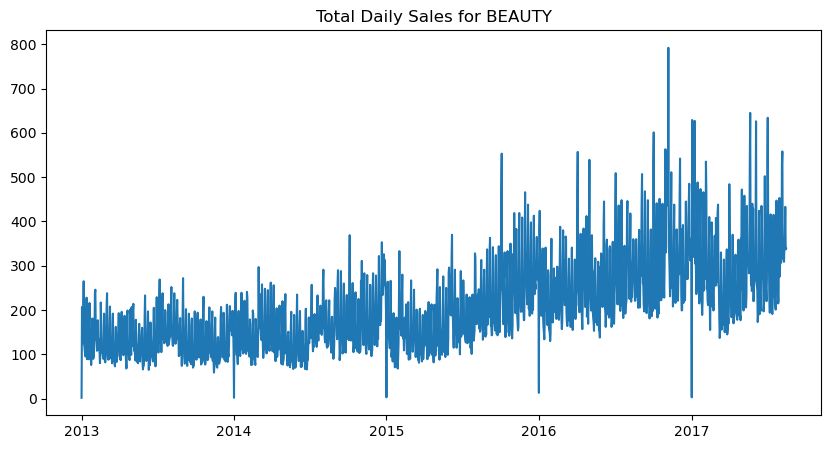

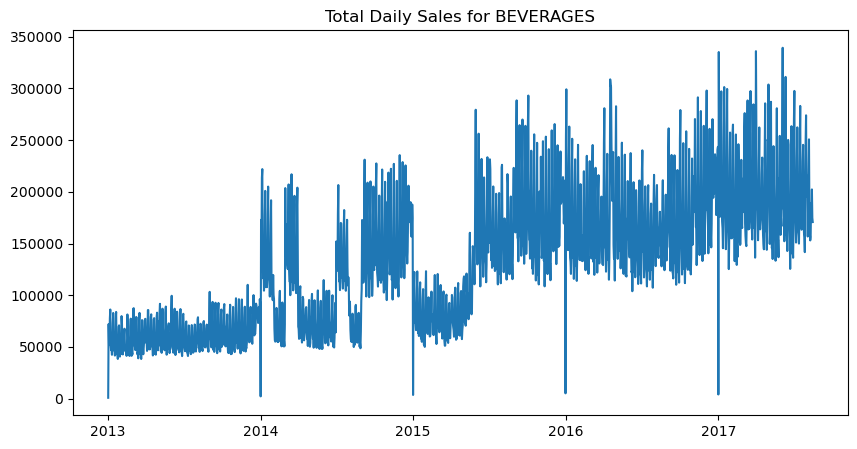

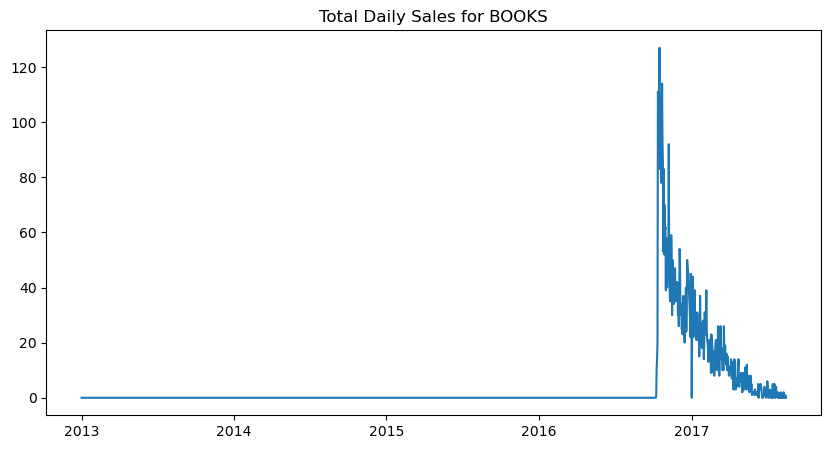

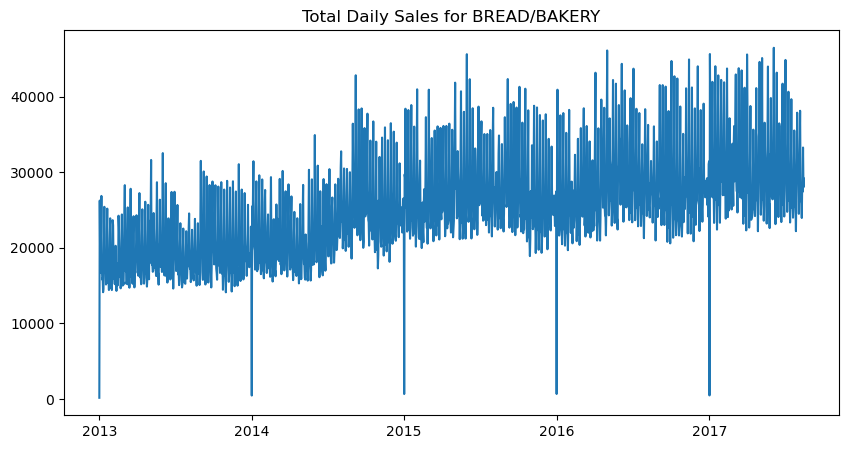

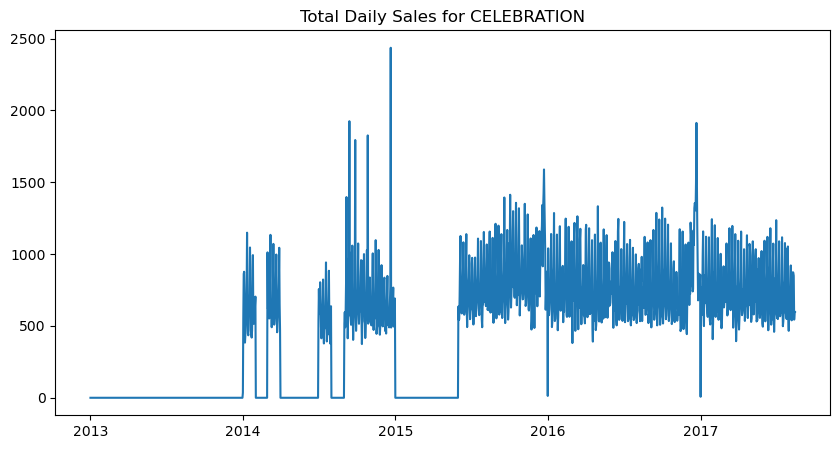

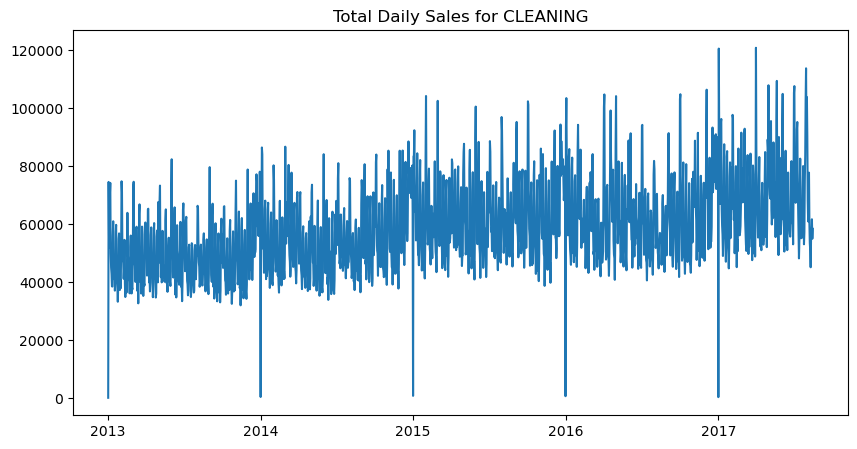

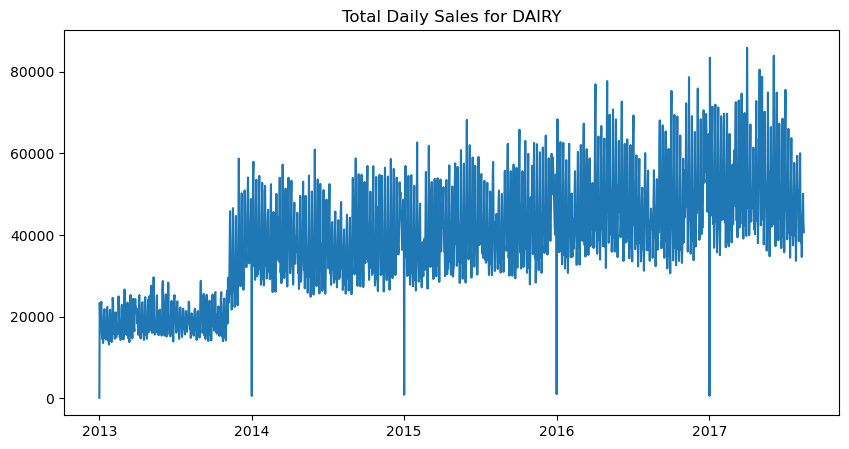

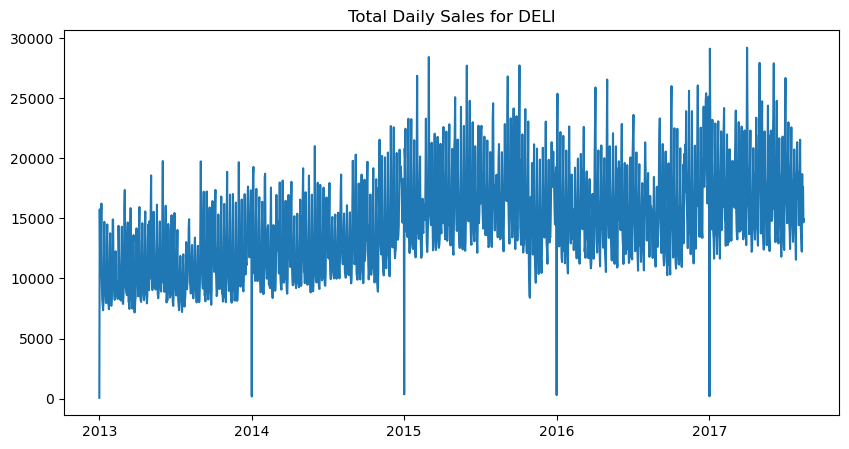

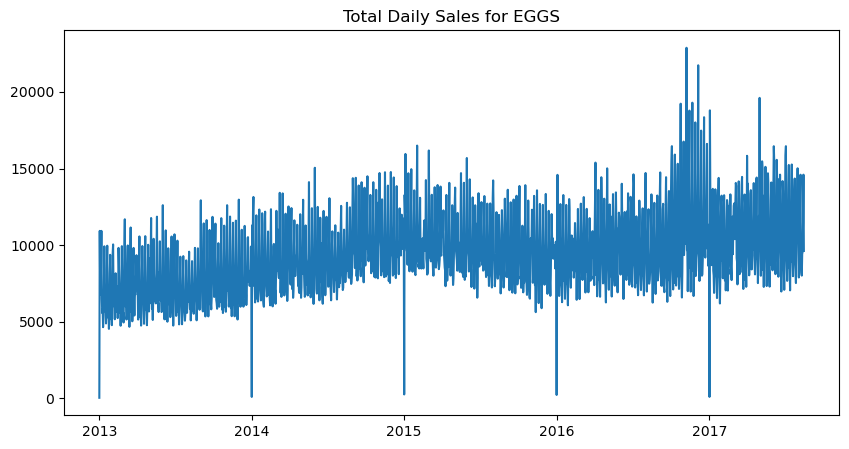

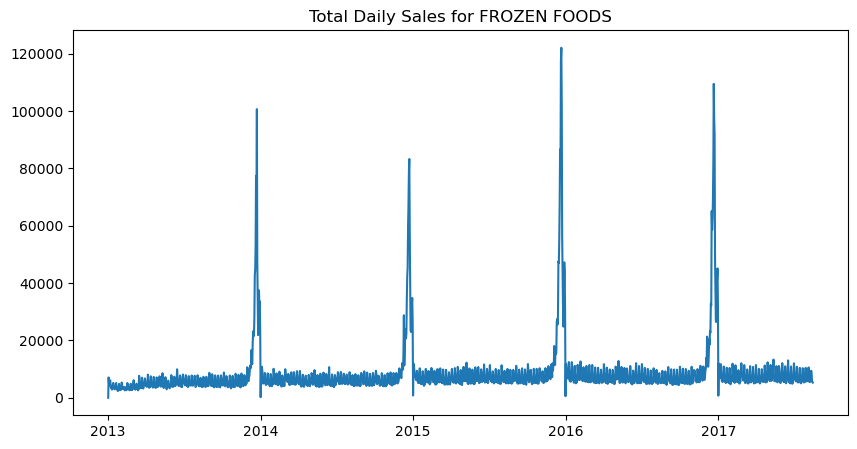

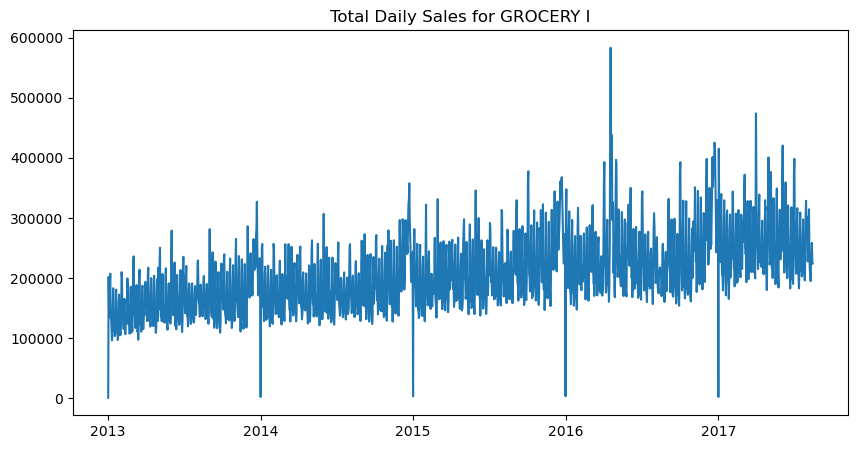

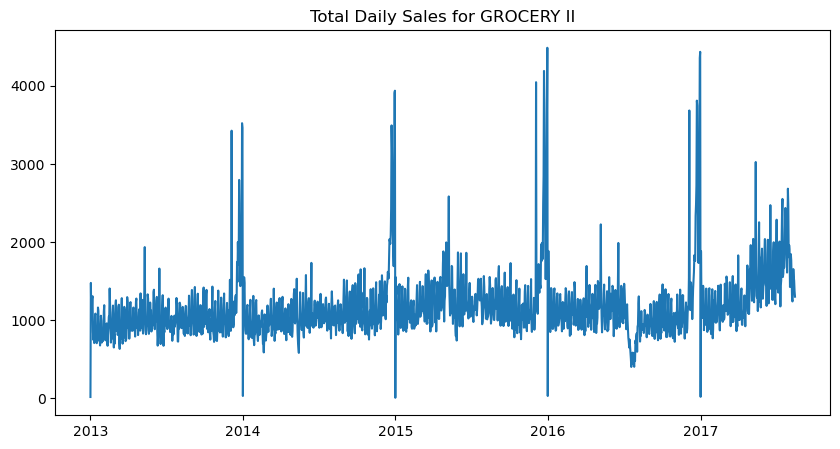

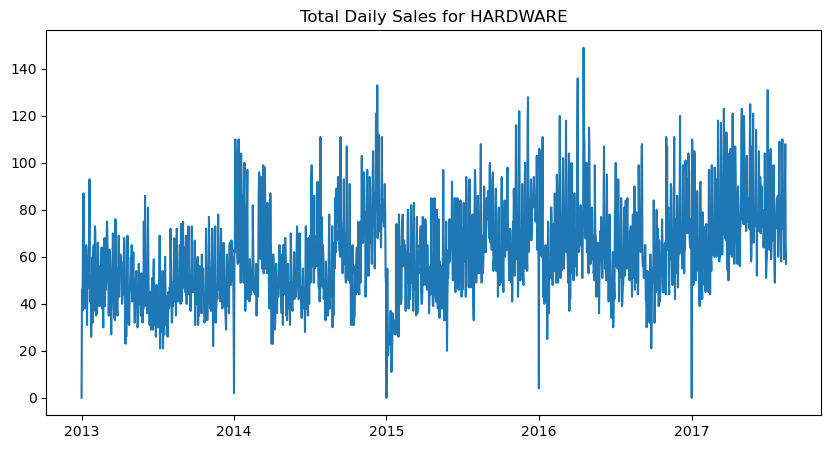

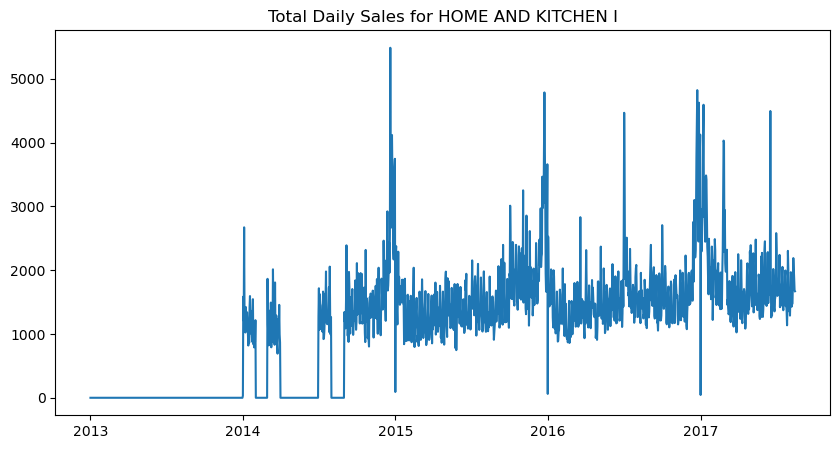

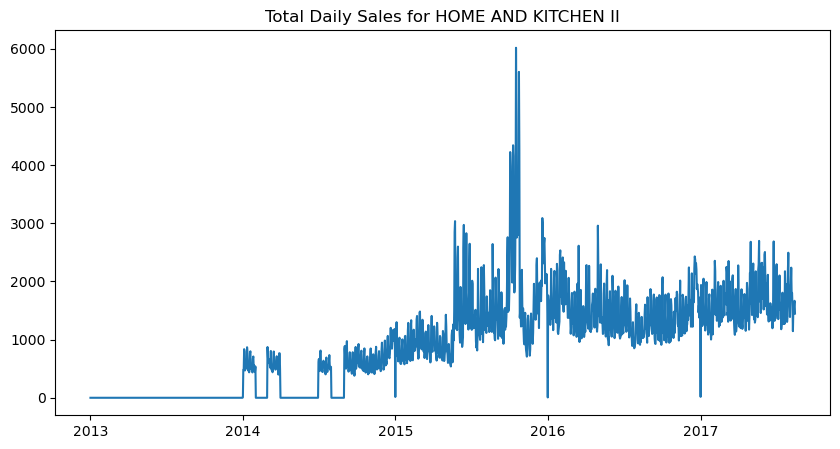

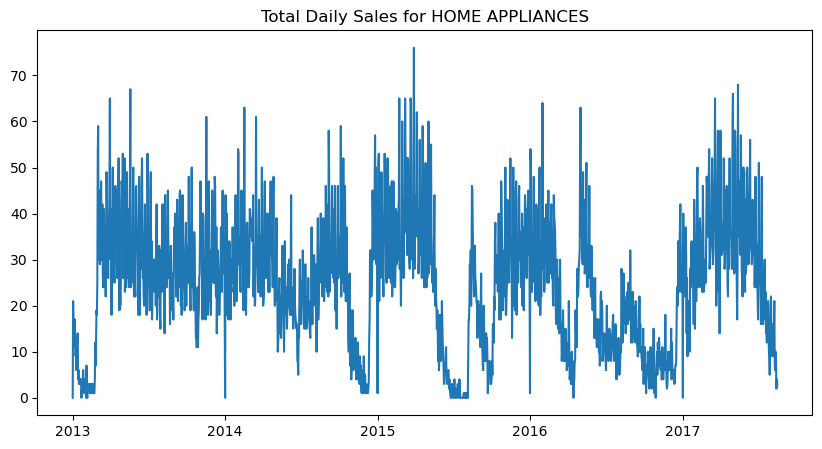

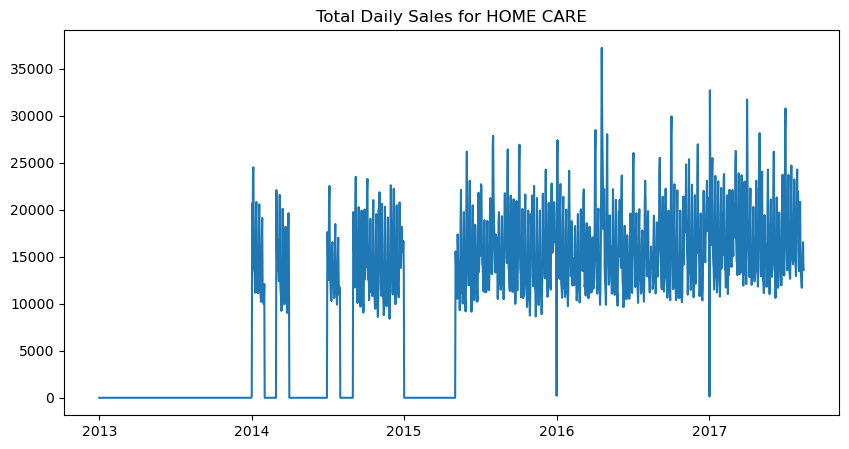

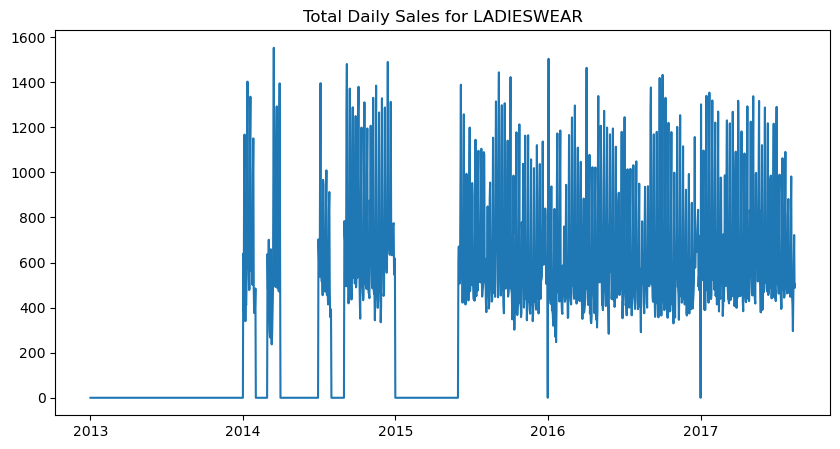

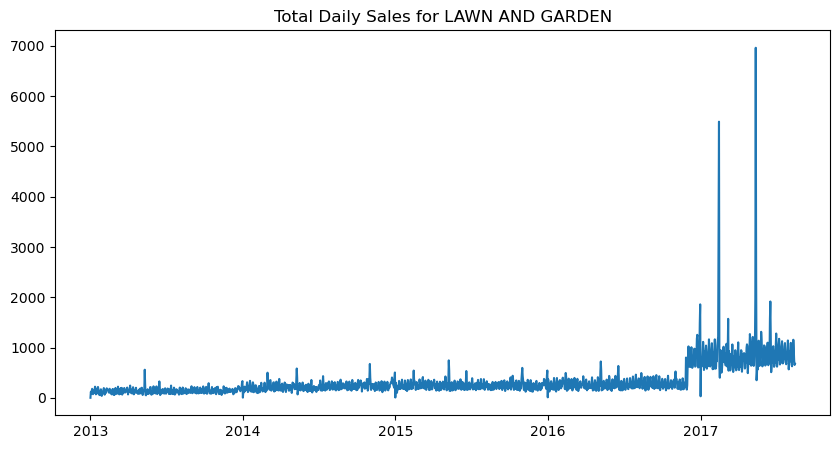

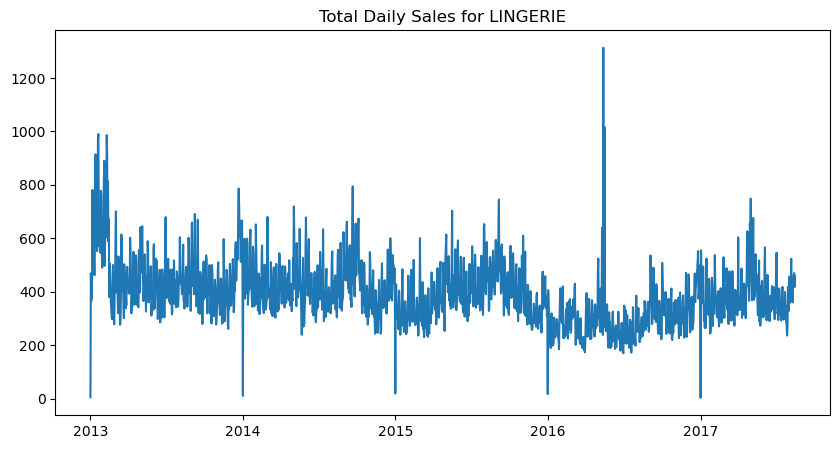

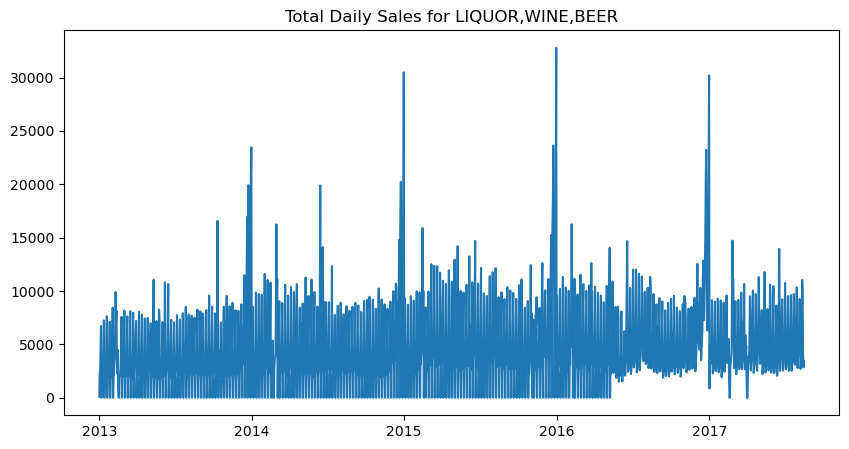

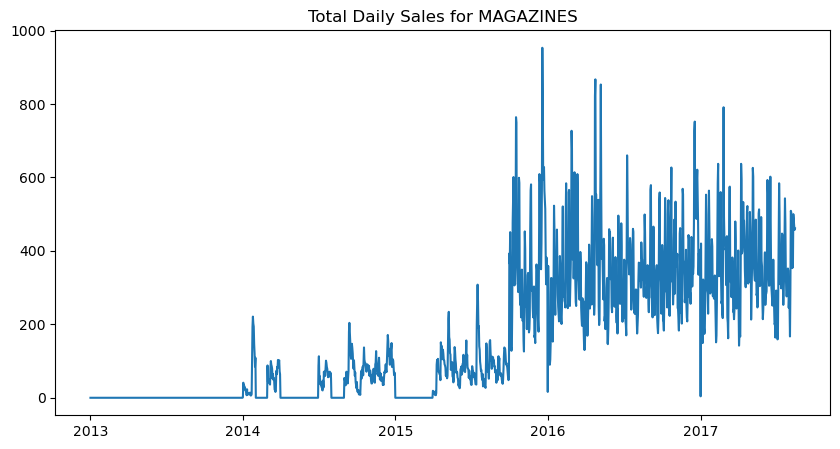

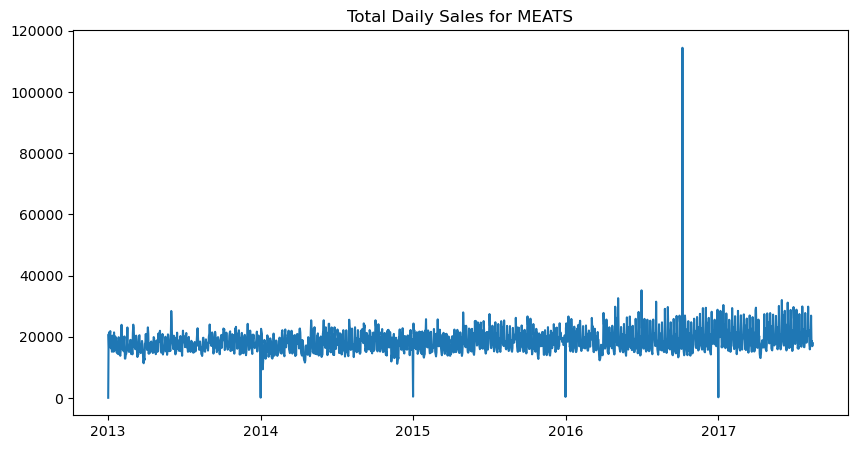

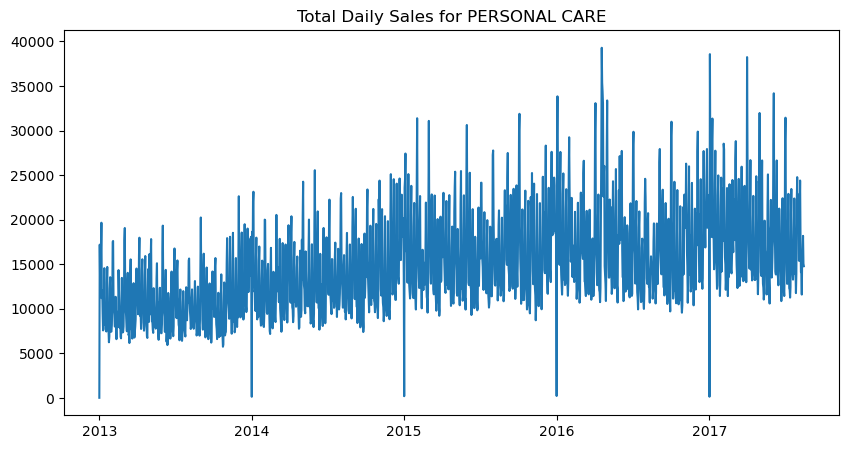

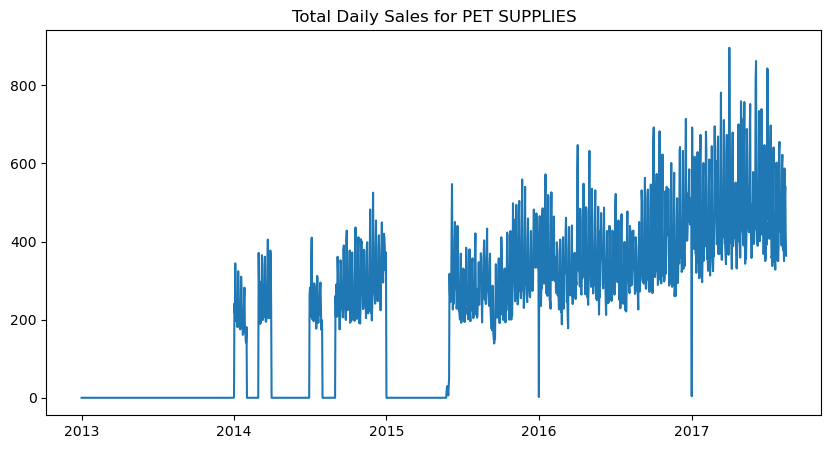

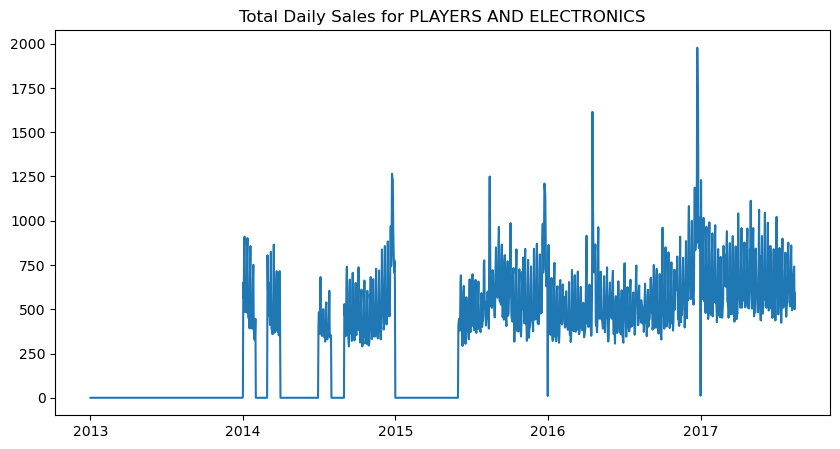

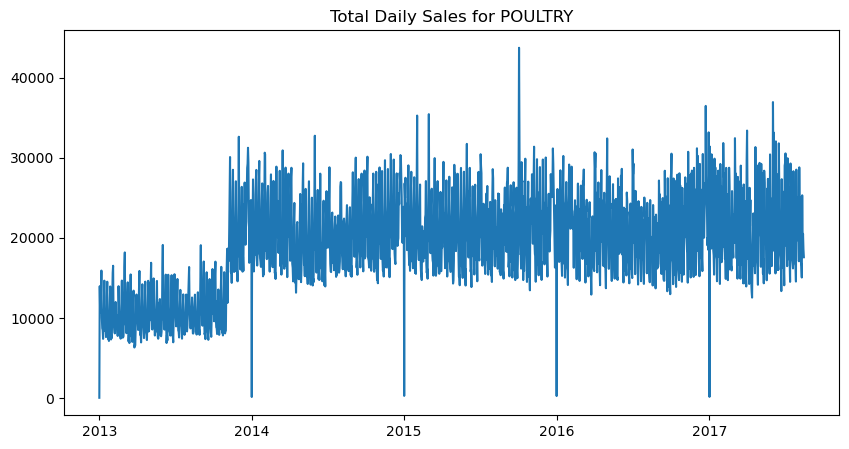

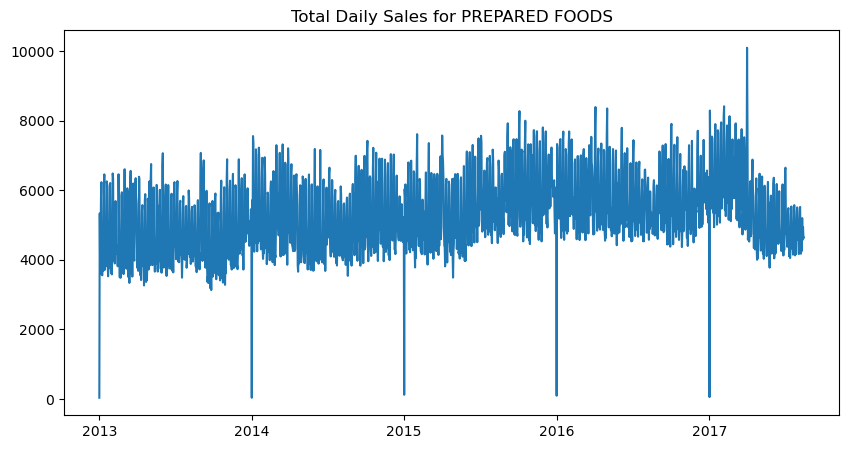

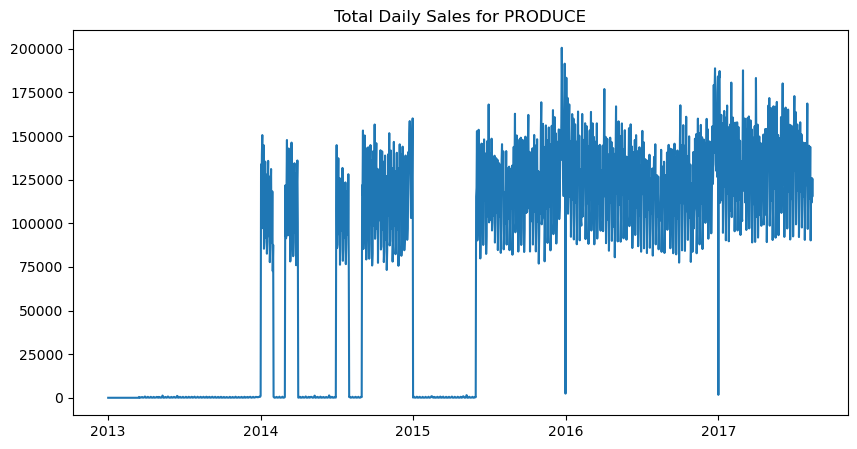

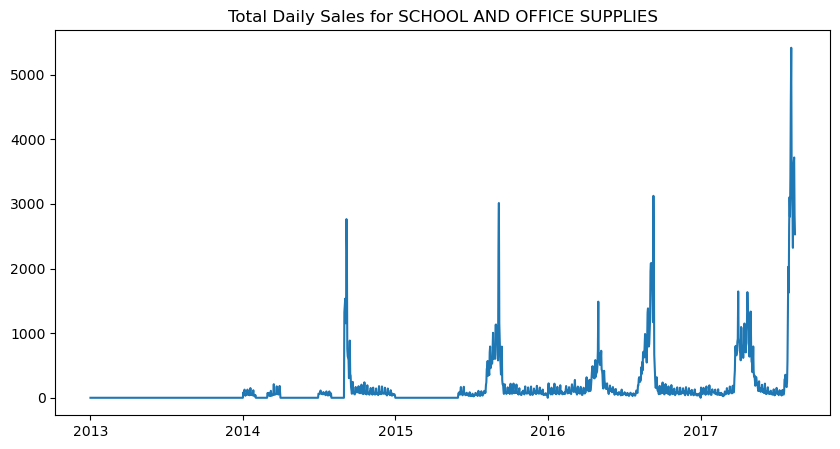

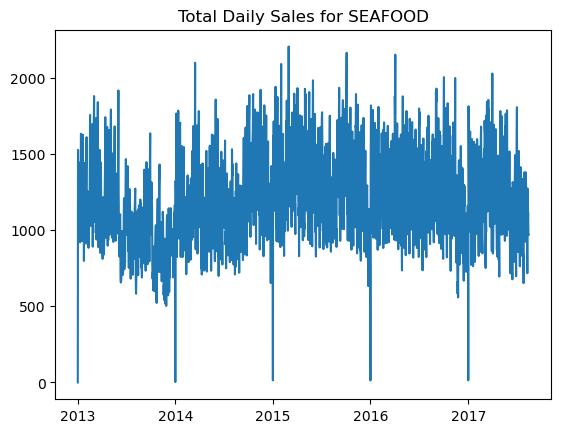

In [9]:
#Individual categories
for category in prod_sales.columns:
    plt.gcf().set_size_inches(10, 5)
    plt.figure()
    plt.title(f'Total Daily Sales for {category}')
    plt.plot(prod_sales.index, prod_sales[category])  


####  Data Quality Cleaning
We notice that there is seasonality, in that there are peaks near the end of every year. We also notice that earlier years have poor quantity/consistency of data across categories, we will cut those timeframes off to improve forecasting. We choose to ignore data before 2015, which can heavily influence performance negatively. We choose 3 years before our end date, 8-15-2017. We can test out which earlier years to cut out to improve our performance.

In [10]:
date_filter = prod_sales.index >= '08-15-2015' 
produce_sales_df = prod_sales.loc[date_filter].reset_index()
produce_sales_df.tail()

family,date,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
725,2017-08-11,441.0,7.0,351.0,189111.0,0.0,28204.48600,870.0,55682.0,44909.0,...,500.0,26944.092010,15978.0,587.0,654.0,25318.297990,5199.494021,118738.14300,3523.0,1272.615997
726,2017-08-12,403.0,3.0,369.0,182318.0,0.0,27403.54800,849.0,57935.0,42854.0,...,483.0,17775.650112,15903.0,508.0,712.0,19134.510058,4573.465992,111788.35090,3644.0,1028.030006
727,2017-08-13,481.0,9.0,433.0,202354.0,1.0,33262.75700,544.0,61757.0,50112.0,...,469.0,18633.015039,18188.0,541.0,741.0,20509.265004,4941.509018,125923.80240,3718.0,1118.047000
728,2017-08-14,292.0,9.0,337.0,174832.0,0.0,28002.45700,594.0,55032.0,43050.0,...,457.0,16975.686040,15077.0,417.0,500.0,18597.508060,4647.375002,115257.59598,2826.0,970.679999
729,2017-08-15,337.0,8.0,339.0,170773.0,0.0,29158.19502,597.0,58474.0,40707.0,...,461.0,17928.170944,14787.0,364.0,592.0,17586.709986,4641.522980,125108.97100,2530.0,970.177005


#### Category Percentile-Grouping
We would like to group the categories by their volume sales metrics percentile-wise to visualize the forecasted sales distributions on similar scales. This is for better assessment of our time series modeling due to seasonality. We can then identify categories with high metrics as having more data for a more robust forecast and better prediction, exploring them first.

We chose to resample, aggregating by Months, and also find the mean sales per category (across the entire time). Resampling  allows for the analysis of sales trends and patterns over broader time intervals, which can be beneficial for understanding long-term fluctuations and seasonality. We will use daily AVG sales across time for relative comparisons between categories, when grouping categories by percentiles.

In [11]:
"""
Grouping Categories by Percentile (Average Sales Across Entire Time)
"""
#Avg Sales of Each column Across Entire Time
avg_daily_sales = prod_sales.apply(np.mean, axis = 0)
print("Avg Sales Across Time: \n", avg_daily_sales)

# Calculate quartiles (25th, 50th, 75th percentiles) of avg sales for each category
#Returns Series
# low,mid,high = avg_prod_sales_pivot_m.quantile([0.25, 0.50, 0.75])                                     
low,mid= np.percentile(avg_daily_sales,[33,66])

print("Sales Percentiles:")
print("{percent} \n".format(percent = [low,mid]))


Avg Sales Across Time: 
 family
AUTOMOTIVE                       329.466746
BABY CARE                          5.968527
BEAUTY                           200.649050
BEVERAGES                     128832.830166
BOOKS                              3.823040
BREAD/BAKERY                   25020.157706
CELEBRATION                      452.005344
CLEANING                       57910.504157
DAIRY                          38294.364014
DELI                           14317.293628
EGGS                            9256.707838
FROZEN FOODS                    8357.415511
GROCERY I                     203956.493400
GROCERY II                      1165.538599
HARDWARE                          61.442993
HOME AND KITCHEN I              1105.398456
HOME AND KITCHEN II              903.010689
HOME APPLIANCES                   24.703682
HOME CARE                       9514.693587
LADIESWEAR                       386.673990
LAWN AND GARDEN                  325.915677
LINGERIE                         387.834917


In [12]:
#Get categories belonging to specific quantiles
low_cat = avg_daily_sales[avg_daily_sales <= low].index
mid_cat = avg_daily_sales[ (avg_daily_sales.values >low) & (avg_daily_sales.values <= mid)].index
high_cat = avg_daily_sales[avg_daily_sales.values > mid].index

print(f"The low quartile categories are: \n {low_cat} \n")
print(f"The low quartile categories are: \n {mid_cat} \n")
print(f"The low quartile categories are: \n {high_cat} \n")

The low quartile categories are: 
 Index(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BOOKS', 'HARDWARE',
       'HOME APPLIANCES', 'LAWN AND GARDEN', 'MAGAZINES', 'PET SUPPLIES',
       'PLAYERS AND ELECTRONICS', 'SCHOOL AND OFFICE SUPPLIES'],
      dtype='object', name='family') 

The low quartile categories are: 
 Index(['CELEBRATION', 'EGGS', 'FROZEN FOODS', 'GROCERY II',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'LADIESWEAR', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'PREPARED FOODS', 'SEAFOOD'],
      dtype='object', name='family') 

The low quartile categories are: 
 Index(['BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DAIRY', 'DELI', 'GROCERY I',
       'HOME CARE', 'MEATS', 'PERSONAL CARE', 'POULTRY', 'PRODUCE'],
      dtype='object', name='family') 



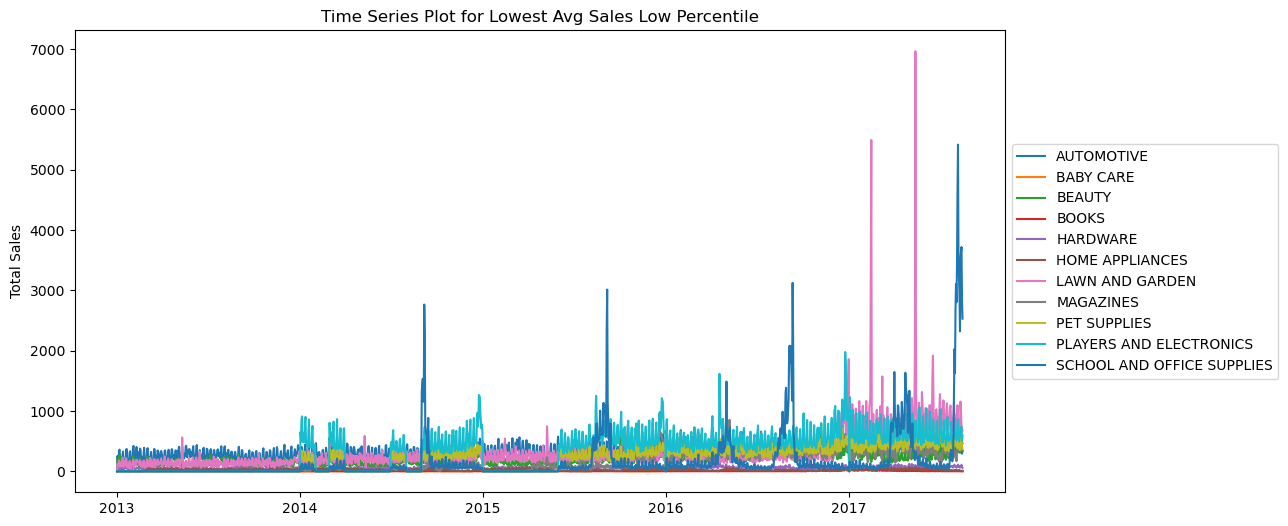

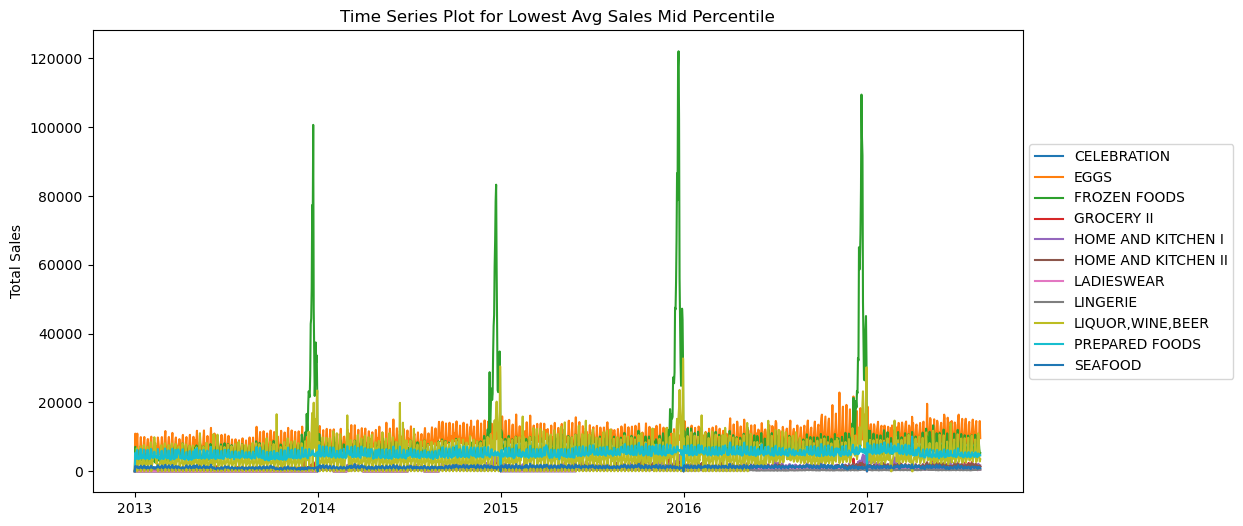

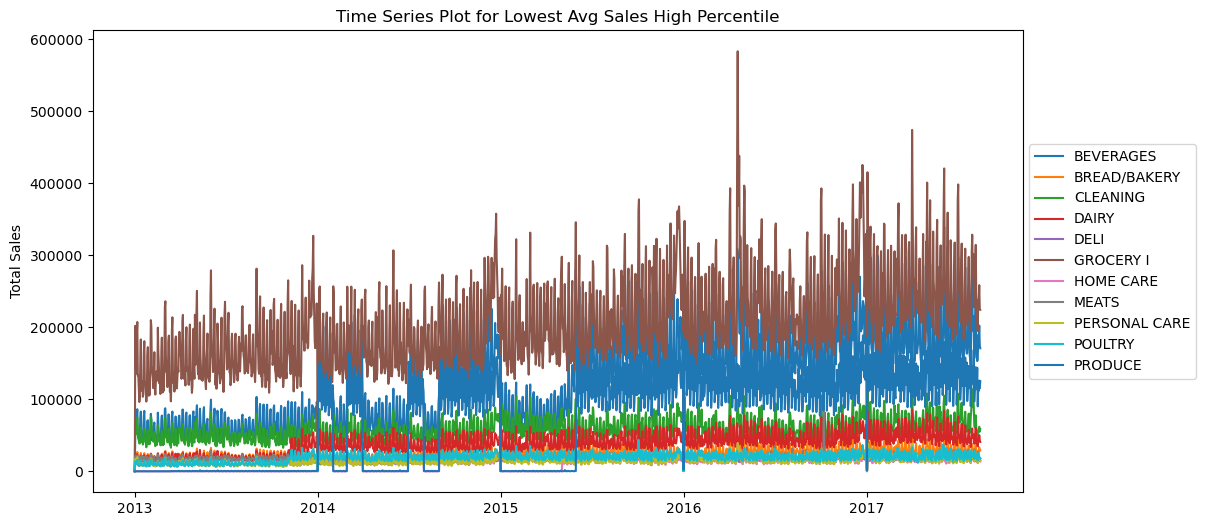

In [13]:
""""
Plot categories in Same Percentile
by Total Sales 
"""
percent_col = [low_cat, mid_cat, high_cat]
percentiles = ["Low", "Mid", "High"]

for percent_col, percentile in zip(percent_col, percentiles): #Want them to correlate to other in the same position, can't use dict
        plt.gcf().set_size_inches(12, 6)
        plt.plot(prod_sales[percent_col])
        plt.ylabel('Total Sales')
        plt.title(f'Time Series Plot for Lowest Avg Sales {percentile} Percentile')
        plt.legend(percent_col, loc='center left', bbox_to_anchor=(1, 0.5))

        plt.show()

### ML Method: Prophet

We would use one of the high percentile categories and predict next 30 days with our designed forecasting model using Facebooks's PROPHET library.
    https://facebook.github.io/prophet/ is the documentation. We will use the https://pypi.org/project/holidays/ python library to get the hoiday data.

Given examples from the PROPHET documentation that there's an option to address holiday effects as part of seasonality, it is noted that Ecuardorian holidays have to be used to reflect the dataset. This then leads to the need of the columns holiday and date. With the specific python library *holiday* which can be customized to desired country, and will result in the name of the holiday as well as the date, we will use a window of 2 days before and after the holiday, accounting for seasonality. Holidays can have significant impact on affecting the performance of our model, as well as other parameters/factors in our PROPHET Model.

The created df will be utilized later during OPTIMIZATION/HYPERPARAMETER Tuning of our model.


In [14]:
from datetime import date
import holidays
"""
Create holiday data: 
Use the holiday library to confirm which dates are holidays
    superbowls = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
    'lower_window': 0,
    'upper_window': 1,
    })
"""
#Initalize holiday df
holiday_df = pd.DataFrame()

#For all days between 2015-2018, create holiday with specificed columns, concatenate
for date_, holiday_name in sorted(holidays.EC(years=[2015, 2016,2017, 2018]).items()): # https://python-holidays.readthedocs.io/en/latest/examples.html  
    # print(date_, holiday_name)
    one_holiday = pd.DataFrame([{
    'holiday': holiday_name,
    'ds': pd.to_datetime(date_),
    'lower_window': -2,
    'upper_window': 2,
    }])
    holiday_df = pd.concat([holiday_df,one_holiday]).sort_values('ds')
holiday_df.head()

,holiday,ds,lower_window,upper_window
0,Año Nuevo,2015-01-01,-2,2
0,Carnaval,2015-02-16,-2,2
0,Carnaval,2015-02-17,-2,2
0,Viernes Santo,2015-04-03,-2,2
0,Día del Trabajo,2015-05-01,-2,2


### Mathematical Principle Prophet

For the math behind PROPHET, it uses a decomposable timeseries model with many components — such as trend, seasonality and holidays, where all time series is a regression model (tests correlation between dependent and independent variables) and built on the Fourier series-a math principle stating that the lines/trends in time series is composed of a sines and cosines.


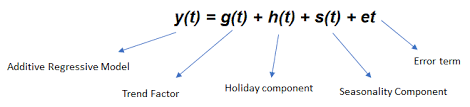

Prophet(growth='linear', changepoint_range = changepoint_range, 
       yearly_seasonality = True, weekly_seasonality = True, 
       daily_seasonality = False, seasonality_mode='multiplicative', holidays=holiday) 

### Engineering our Model
We would want to train our model on specified sales before our intended forcasting date. Then for prediction, we will specify how much time forward do we want to forecast up to, by selecting a specific time period 'horizon', and to finally predict our forecasted sales value.
If our forecasting horizon increases, there is a higher chance of forecastng errors and overfitting of our model due to various factors. Some examples are:

       - Model Uncertainty: As the forecasting horizon increases, the uncertainty associated with future predictions also grows. This uncertainty can arise from various sources such as random fluctuations, missing data, or unforeseen events.

       -Seasonality and Trends: Seasonal patterns and long-term trends in the data may become less predictable or more variable over longer time horizons, making it challenging for the model to accurately capture and forecast these patterns.

In [15]:
"""
Forecasting Known Sales Period, 
Backtracking to check Prediction Robustness
W/ Historical Data

"""
from datetime import date
from prophet import Prophet

forecast_date = date(2017,7,1) #2017-08-15 is last date of dataset --> forecasting on that day forward

#Prepare Historical Data --> ds, y columns
train_set_df = produce_sales_df[ (produce_sales_df['date'] < '2017-07-01') ]
train_set_df= train_set_df.rename(columns={'PRODUCE': 'y', 'date': 'ds'})

#Fit PROPHET Model with Historical Data
prophet_model = Prophet(holidays = holiday_df, yearly_seasonality = True)  # Can Specify optimization algorithm, seasonality heavily affects model 
prophet_model.fit(train_set_df)

#Make Future Dataframe, Including Historical Dates  --> Specify future forecast period from historical data
predicted_days = 30 
future_df = prophet_model.make_future_dataframe(periods = predicted_days)

#Predict with future dates
forecast_df = prophet_model.predict(future_df)

filter = forecast_df['ds'] >= '2017-07-01'
forecast_df = forecast_df[filter][['ds', 'yhat']]
forecast_df

19:10:27 - cmdstanpy - INFO - Chain [1] start processing
19:10:28 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat
684,2017-07-01,139612.671680
685,2017-07-02,152996.504280
686,2017-07-03,116082.762787
687,2017-07-04,120713.723174
688,2017-07-05,152572.295268
689,2017-07-06,93974.643878
690,2017-07-07,109425.632430
691,2017-07-08,138300.017403
692,2017-07-09,151815.002431
693,2017-07-10,115048.868490


In [16]:
"""
Create DataFrame with ds, yhat, ytrue
"""
produce_sales_copy = produce_sales_df.copy()

#df of Sales data not part of forecasted time
actual_values = produce_sales_copy[(produce_sales_copy['date'] >= '2017-07-01') 
                                   ][['date','PRODUCE']]
actual_values = actual_values.rename(columns = {'date': 'ds', 'PRODUCE': 'ytrue'}).reset_index(drop=True)

predicted_values = forecast_df.copy()

# print(len(actual_values), len(predicted_values) ) #Check if they have the same prediction dates
# actual_values.reset_index(drop=True).compare(predicted_values)
# print(actual_values.reset_index(drop=True))

#Merge actual and predicted values (forecast_df) on date
predicted_df = actual_values.merge(predicted_values, how = 'inner', on = 'ds' )
predicted_df = predicted_df.reindex(columns=['ds', 'ytrue', 'yhat'])
# actual_values
# forecast_df
predicted_df

,ds,ytrue,yhat
0,2017-07-01,155487.63090,139612.671680
1,2017-07-02,172890.13860,152996.504280
2,2017-07-03,130389.19902,116082.762787
3,2017-07-04,131534.54802,120713.723174
4,2017-07-05,163804.33003,152572.295268
5,2017-07-06,99395.60498,93974.643878
6,2017-07-07,114346.57410,109425.632430
7,2017-07-08,139294.77300,138300.017403
8,2017-07-09,156633.92050,151815.002431
9,2017-07-10,118856.99105,115048.868490


In [17]:
"Evaluate and Calculate Performance Metrics (MAPE)"
predicted_df['mape'] = (predicted_df['ytrue'] - predicted_df['yhat'])/ predicted_df['ytrue'] *100
predicted_df

,ds,ytrue,yhat,mape
0,2017-07-01,155487.63090,139612.671680,10.209789
1,2017-07-02,172890.13860,152996.504280,11.506518
2,2017-07-03,130389.19902,116082.762787,10.972102
3,2017-07-04,131534.54802,120713.723174,8.226603
4,2017-07-05,163804.33003,152572.295268,6.856983
5,2017-07-06,99395.60498,93974.643878,5.453924
6,2017-07-07,114346.57410,109425.632430,4.303532
7,2017-07-08,139294.77300,138300.017403,0.714137
8,2017-07-09,156633.92050,151815.002431,3.076548
9,2017-07-10,118856.99105,115048.868490,3.203953


Since our RSME is just in the ten-thousands and our total sales are in the hundred thousands, we can temporarily note that it is a 'good' RSME score. We will still need to perform cross validation, as well as comprehensively get all the relevant performance metrics.

### Cross-Validation and HyperParameter Tuning
Cross Validation measures forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point and forecasting up to a certain period of time over the entire time frame repeatedly. We can then compare the forecasted values to the actual values.  

Perform time-series cross-validation first to assess and evaluate the effectiveness of the model, we use cross validation to normalize our predictions due to inconsistency of cutoff days or noise, for more accurate metrics and more robust testing, decreasing overfitting and increasing accuracy (100-MAPE).
Then, perform hyperparameter tuning to further optimize model, including cross-validation, with performance statistics such as Mean Absolute Percent Error (MAPE). https://facebook.github.io/prophet/docs/diagnostics.html 


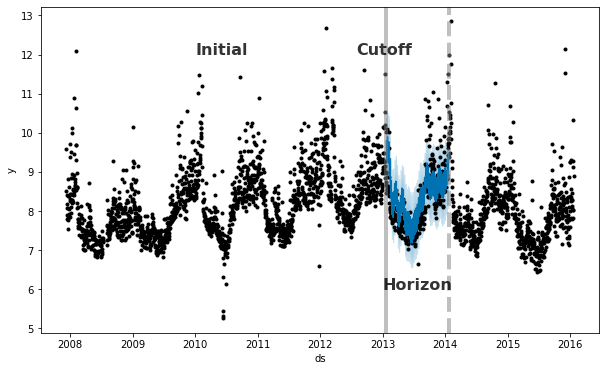

We would choose an 'inital' period in which the model is trained on up to that point to fit the model and predict error comparing true vs. predicted values over a specified number of days (MAPE) until our cutoff date, then we would perform the same window calculations to the next initial date, averaging the accuracies to get reliable results.

Example would be our inital period specified is 2014/7/1, and we would forecast/predict the values from the observed values from the cutoff + horizon date (365 days, so until 2015/7/1). We woiuld keep forecasting the chunks of dates and their metrics, then calculating the mean absolute percentage error (MAPE) from the sections.

Note: We generally exclude holidays from the training data used in each fold of the cross-validation process. Including holidays in the training data for each fold could lead to data leakage and biased evaluation of the model's performance.

In [18]:
""" 
Cross Validation Without Hyperparameter Tuning, 
Standard PROPHET Model
"""
from prophet.diagnostics import cross_validation, performance_metrics

# Perform cross-validation, where we predict next 30 days and assess forecast error
prophet_model = Prophet()
prophet_model.fit(train_set_df)

df_cv = cross_validation(prophet_model, initial='365 days', period='30 days', horizon = '30 days');

df_cv

#training set
#start date: 8/15/2015
#end date: 8/15/2016

#training set
#start date: 8/15/2015
#end date: 9/15/2016

# ... continued 

19:10:29 - cmdstanpy - INFO - Chain [1] start processing
19:10:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/10 [00:00<?, ?it/s]

19:10:29 - cmdstanpy - INFO - Chain [1] start processing
19:10:29 - cmdstanpy - INFO - Chain [1] done processing
19:10:30 - cmdstanpy - INFO - Chain [1] start processing
19:10:30 - cmdstanpy - INFO - Chain [1] done processing
19:10:30 - cmdstanpy - INFO - Chain [1] start processing
19:10:30 - cmdstanpy - INFO - Chain [1] done processing
19:10:30 - cmdstanpy - INFO - Chain [1] start processing
19:10:30 - cmdstanpy - INFO - Chain [1] done processing
19:10:31 - cmdstanpy - INFO - Chain [1] start processing
19:10:31 - cmdstanpy - INFO - Chain [1] done processing
19:10:31 - cmdstanpy - INFO - Chain [1] start processing
19:10:31 - cmdstanpy - INFO - Chain [1] done processing
19:10:32 - cmdstanpy - INFO - Chain [1] start processing
19:10:32 - cmdstanpy - INFO - Chain [1] done processing
19:10:32 - cmdstanpy - INFO - Chain [1] start processing
19:10:32 - cmdstanpy - INFO - Chain [1] done processing
19:10:32 - cmdstanpy - INFO - Chain [1] start processing
19:10:33 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-09-04,137039.270004,120194.413471,153167.073599,144954.38760,2016-09-03
1,2016-09-05,103690.379850,87183.088703,120202.013301,110104.67900,2016-09-03
2,2016-09-06,107783.517963,89734.223044,124625.492206,115898.16200,2016-09-03
3,2016-09-07,140063.590745,122408.012495,156249.618115,142809.14899,2016-09-03
4,2016-09-08,84274.684619,66391.173103,100533.219078,85680.68464,2016-09-03
...,...,...,...,...,...,...
294,2017-06-26,123282.090527,103000.540307,142123.389834,113866.37700,2017-05-31
295,2017-06-27,128458.365407,110562.687256,148325.355254,118274.73790,2017-05-31
296,2017-06-28,161001.204776,142306.168109,180018.717547,154674.94002,2017-05-31
297,2017-06-29,103736.894754,84732.576192,122833.523244,92482.67185,2017-05-31


In [19]:
# Calculate performance metrics
df_cv_metrics = performance_metrics(df_cv)
df_cv_metrics

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,4.133612e+08,20331.285570,13110.675549,0.089795,0.065852,0.096021,0.800000
1,4 days,2.703561e+08,16442.508418,11138.397264,0.079789,0.058256,0.083668,0.803448
2,5 days,1.419225e+08,11913.124245,8919.139012,0.067913,0.056825,0.070012,0.865517
3,6 days,1.266368e+08,11253.301413,9242.824974,0.071520,0.071845,0.073553,0.868966
4,7 days,9.639713e+07,9818.204116,8434.362030,0.066436,0.069632,0.067274,0.934483
5,8 days,7.637333e+07,8739.183621,7696.800517,0.061047,0.064641,0.060967,0.968966
6,9 days,6.148068e+07,7840.961594,6605.295404,0.055089,0.043894,0.053913,0.965517
7,10 days,4.933398e+07,7023.815190,5436.307997,0.047213,0.037743,0.045525,0.965517
8,11 days,7.869303e+07,8870.909452,6725.698276,0.054882,0.041412,0.053712,0.934483
9,12 days,8.338613e+07,9131.600620,6726.871201,0.052272,0.046883,0.052020,0.931034


MAPE is interpreted percentage-wise, so 0.01 is 1% MAPE. The Accuracy is (1-MAPE) or 91%.

We notice that the MAPE values are reasonable between 0-15% MAPE, but with an outlier on the 30th predicted day, 300% MAPE.

### Granulare Prediction (Daily level)
For more granular scale with the daily dates with our cross-validated metrics, we would calculate the daily differences using the mape metric. This is to detect issues in predicting certain time periods, which are inherent issues in the data that you may or may not be able to fix. Timeseries is the prime example that garbage in is going to be garbage out.

In [20]:
"""
Calculating MAPE on daily level, identifying overestimates
"""
df_cv['mape'] = (df_cv['y']-df_cv['yhat'])/(df_cv['y'])*100
df_cv['overestimate'] = df_cv['yhat'] > df_cv['y'] 

#Look at dates with high MAPE 
df_cv_daily = df_cv.sort_values('mape',ascending=False)
df_cv_daily.head(15)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape,overestimate
110,2016-12-23,98436.012033,83039.121997,114426.879230,176327.96600,2016-12-02,44.174475,False
116,2016-12-30,98482.273012,83415.893451,113363.526375,175022.19400,2016-12-02,43.731552,False
109,2016-12-22,87948.805122,72478.111550,103537.142802,140444.94200,2016-12-02,37.378446,False
119,2017-01-02,116970.371211,98093.270130,136622.454511,184113.02890,2017-01-01,36.468173,False
120,2017-01-03,121230.033775,103103.172995,140512.008485,183306.22680,2017-01-01,33.864749,False
111,2016-12-24,127835.655155,111752.368399,143502.363313,188809.16200,2016-12-02,32.293723,False
117,2016-12-31,127881.916135,112267.171114,142043.681430,184154.66900,2016-12-02,30.557332,False
115,2016-12-29,87995.066101,71675.350520,103547.560985,126652.83900,2016-12-02,30.522626,False
238,2017-05-01,126221.698834,106923.142924,147357.919469,167558.57600,2017-04-01,24.670105,False
108,2016-12-21,143739.733439,127589.131631,158068.709333,179251.71297,2016-12-02,19.811236,False


We notice that there is a severe underprediction of sales around end of December of each year. This could've affected our predictions. We notice that from the plot of Produce sales that there is a abnormal dip in sales, skewing predictions. The data 'in' was off, resulting in 300% MAPE near end of December.

(array([16709., 16801., 16892., 16983., 17075., 17167., 17257., 17348.]),
 [Text(16709.0, 0, '2015-10'),
  Text(16801.0, 0, '2016-01'),
  Text(16892.0, 0, '2016-04'),
  Text(16983.0, 0, '2016-07'),
  Text(17075.0, 0, '2016-10'),
  Text(17167.0, 0, '2017-01'),
  Text(17257.0, 0, '2017-04'),
  Text(17348.0, 0, '2017-07')])

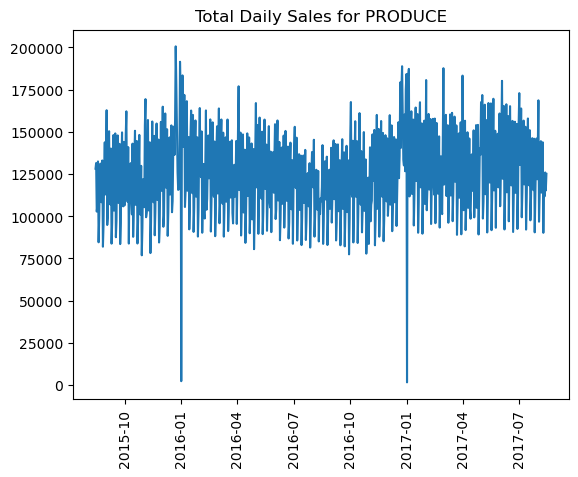

In [21]:
plt.title(f'Total Daily Sales for PRODUCE')
plt.plot(produce_sales_df['date'], produce_sales_df['PRODUCE'])
plt.xticks(rotation = 90)  

### Model Optimization and Hyperparameter Tuning

In [22]:
import itertools
""" Hyperparameter Tuning with Cross-Validation"""
#weights
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train_set_df)  # Fit model with given params
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

19:10:34 - cmdstanpy - INFO - Chain [1] start processing
19:10:34 - cmdstanpy - INFO - Chain [1] done processing
19:10:44 - cmdstanpy - INFO - Chain [1] start processing
19:10:44 - cmdstanpy - INFO - Chain [1] done processing
19:10:54 - cmdstanpy - INFO - Chain [1] start processing
19:10:54 - cmdstanpy - INFO - Chain [1] done processing
19:11:03 - cmdstanpy - INFO - Chain [1] start processing
19:11:03 - cmdstanpy - INFO - Chain [1] done processing
19:11:13 - cmdstanpy - INFO - Chain [1] start processing
19:11:13 - cmdstanpy - INFO - Chain [1] done processing
19:11:22 - cmdstanpy - INFO - Chain [1] start processing
19:11:22 - cmdstanpy - INFO - Chain [1] done processing
19:11:30 - cmdstanpy - INFO - Chain [1] start processing
19:11:30 - cmdstanpy - INFO - Chain [1] done processing
19:11:39 - cmdstanpy - INFO - Chain [1] start processing
19:11:39 - cmdstanpy - INFO - Chain [1] done processing
19:11:49 - cmdstanpy - INFO - Chain [1] start processing
19:11:50 - cmdstanpy - INFO - Chain [1]

In [23]:
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                     0.01  18782.744407
1                     0.001                     0.10  18893.212747
2                     0.001                     1.00  18576.718945
3                     0.001                    10.00  18559.792562
4                     0.010                     0.01  18219.078433
5                     0.010                     0.10  17783.847283
6                     0.010                     1.00  17762.833451
7                     0.010                    10.00  17719.628321
8                     0.100                     0.01  18055.734483
9                     0.100                     0.10  17747.484855
10                    0.100                     1.00  17724.970016
11                    0.100                    10.00  17725.026336
12                    0.500                     0.01  18085.315283
13                    0.500                     0.10  17735.36

In [24]:
#Selecting best param with least RSME
best_param = tuning_results.sort_values('rmse').reset_index(drop = True)

print('Best Params:\n', best_param.iloc[0])

Best Params:
 changepoint_prior_scale        0.010000
seasonality_prior_scale       10.000000
rmse                       17719.628321
Name: 0, dtype: float64


### Finalized Model


In [26]:
def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [27]:
#Fit PROPHET Model with Historical Data
fin_m = Prophet(holidays = holiday_df, yearly_seasonality = True, changepoint_prior_scale = .01, seasonality_prior_scale = 10)  # Can Specify optimization algorithm, seasonality heavily affects model 
fin_m.fit(train_set_df)

#Make Future Dataframe, Including Historical Dates  --> Specify future forecast period from historical data
fin_future_df = fin_m.make_future_dataframe(periods = predicted_days)

fin_forecast = fin_m.predict(fin_future_df)

fin_forecast_df = fin_forecast[['ds', 'yhat']]
fin_forecast_df = fin_forecast_df.merge(actual_values)
fin_forecast_df

#Calculate MAPE
#Calculate MAPE
mape(fin_forecast_df['ytrue'], fin_forecast_df['yhat'])


00:06:09 - cmdstanpy - INFO - Chain [1] start processing
00:06:09 - cmdstanpy - INFO - Chain [1] done processing


4.341145742656329

Our final forecasting timeseries model has an accuracy of 96% when forecasting 30 days ahead.

c:\Users\cecil\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\cecil\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
c:\Users\cecil\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np

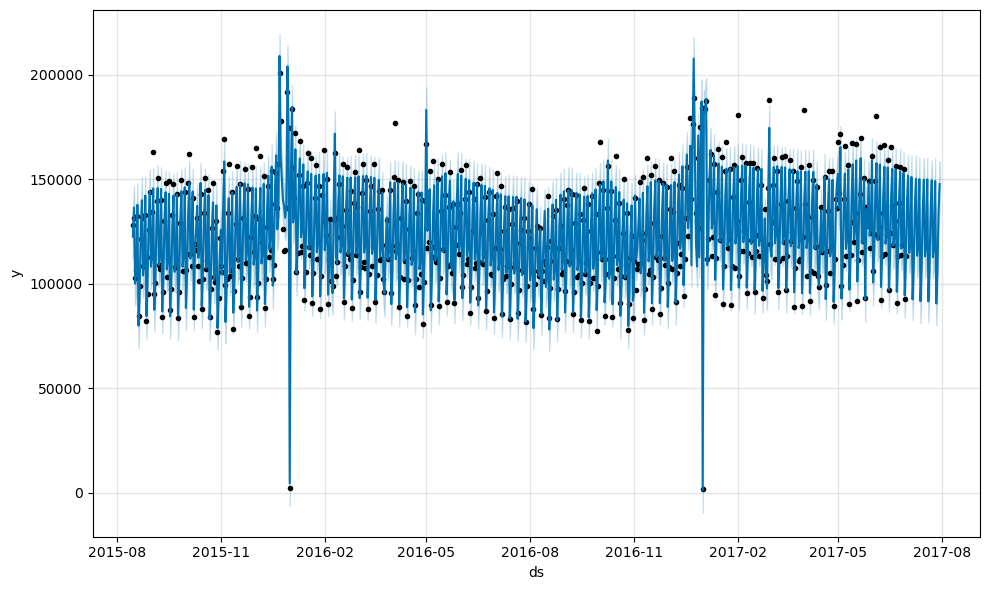

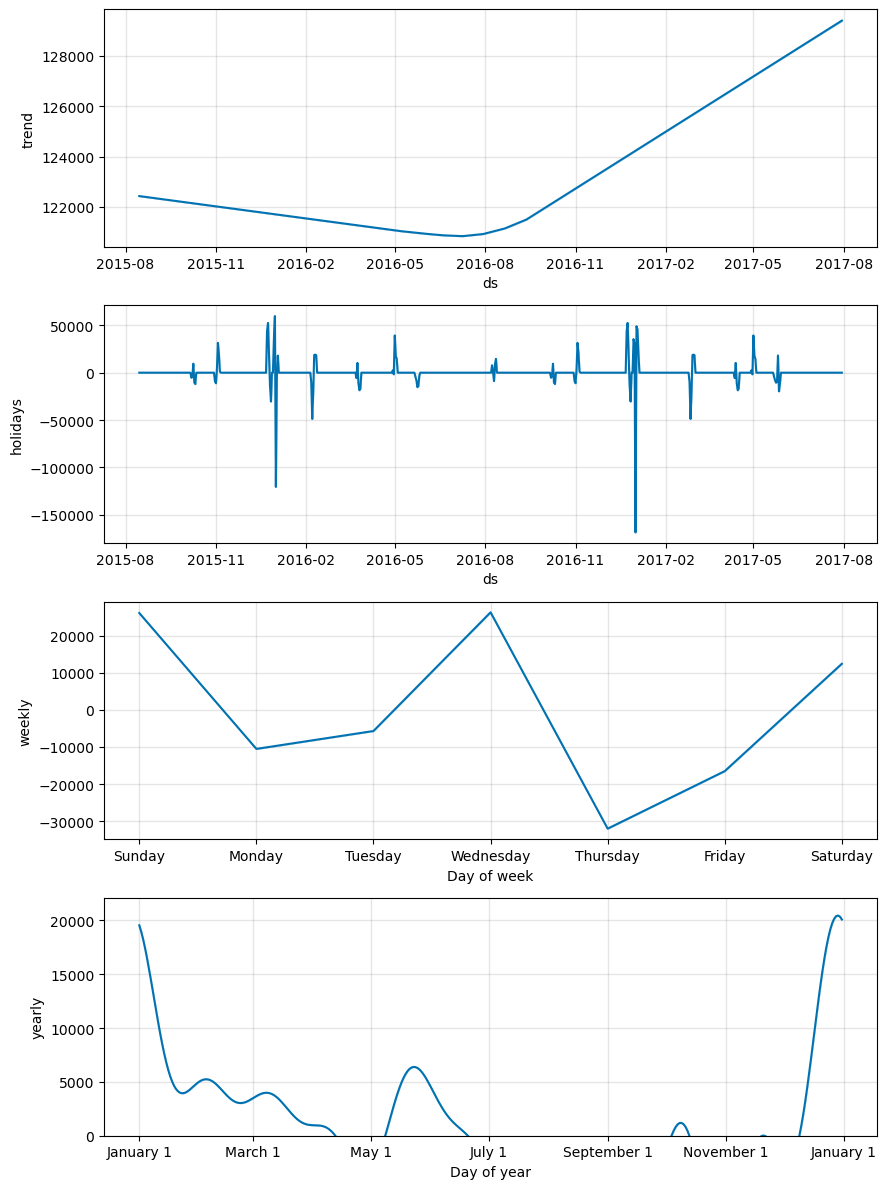

In [28]:
#Plot Visualization
# fin_m.plot(fin_forecast)
# plt.axhline(y=0, color='red')
# plt.title('Best Sales Model for Produce')

from prophet.plot import plot, plot_components
from matplotlib import pyplot as plt

plot(fin_m, fin_forecast)               # Plot the forecast
plot_components(fin_m, fin_forecast)    # Plot the forecast components
plt.ylim(0)
plt.show()

Our model seems to fit with out original sales, but we need to not take the end of the month sales in mind, as they are extreme outliers.